In [1]:
# Fix OpenMP conflict
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Setup

In [2]:
# Add parent directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

In [3]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from gimbal.pymc_distributions import VonMisesFisher
from gimbal.model import SkeletonParameters

print(f"PyMC version: {pm.__version__}")

PyMC version: 5.26.1


## 1. Define Simple Skeleton

Create a simple 3-joint skeleton: root → child1 → child2

In [4]:
# Skeleton structure
K = 3  # Number of joints
T = 20  # Number of time frames

# Parent relationships (root has parent -1)
parents = np.array([-1, 0, 1])  # joint 0 is root, 1 connects to 0, 2 connects to 1

# Skeletal parameters (ground truth for generating data)
true_rho = np.array([0.0, 1.0, 0.8])  # Bone lengths from parent (root has 0)
true_sigma2 = np.array([0.0, 0.01, 0.01])  # Bone length variance
true_eta2 = np.array([0.01, 0.05, 0.05])  # Temporal variance

print(f"Skeleton: {K} joints, {T} frames")
print(f"Parent structure: {parents}")
print(f"Bone lengths: {true_rho}")

Skeleton: 3 joints, 20 frames
Parent structure: [-1  0  1]
Bone lengths: [0.  1.  0.8]


## 2. Generate Synthetic Ground Truth Data

Create realistic skeletal motion following the hierarchical prior.

In [5]:
def generate_skeleton_motion(T, K, parents, rho, sigma2, eta2, seed=42):
    """
    Generate synthetic skeleton motion following hierarchical prior.
    
    Returns:
        x: (T, K, 3) joint positions
        u: (T, K, 3) directional vectors (unit vectors pointing from parent to child)
    """
    rng = np.random.default_rng(seed)
    
    x = np.zeros((T, K, 3))
    u = np.zeros((T, K, 3))
    
    # Initialize root position
    x[0, 0, :] = np.array([0., 0., 0.])
    
    for t in range(T):
        # Root dynamics (random walk)
        if t > 0:
            x[t, 0, :] = x[t-1, 0, :] + rng.normal(0, np.sqrt(eta2[0]), 3)
        
        for k in range(1, K):
            parent_k = parents[k]
            
            # Sample direction (random for now - in full model would use pose priors)
            if t == 0:
                # Initialize with upward direction
                u[t, k, :] = np.array([0., 0., 1.])
            else:
                # Smooth temporal evolution
                prev_dir = u[t-1, k, :]
                # Add small perturbation and renormalize
                new_dir = prev_dir + rng.normal(0, 0.1, 3)
                u[t, k, :] = new_dir / np.linalg.norm(new_dir)
            
            # Sample bone length
            bone_length = rho[k] + rng.normal(0, np.sqrt(sigma2[k]))
            
            # Child position = parent position + length * direction
            x[t, k, :] = x[t, parent_k, :] + bone_length * u[t, k, :]
    
    return x, u

# Generate data
x_true, u_true = generate_skeleton_motion(T, K, parents, true_rho, true_sigma2, true_eta2)

print(f"Generated positions shape: {x_true.shape}")
print(f"Generated directions shape: {u_true.shape}")

Generated positions shape: (20, 3, 3)
Generated directions shape: (20, 3, 3)


## 3. Visualize Generated Skeleton

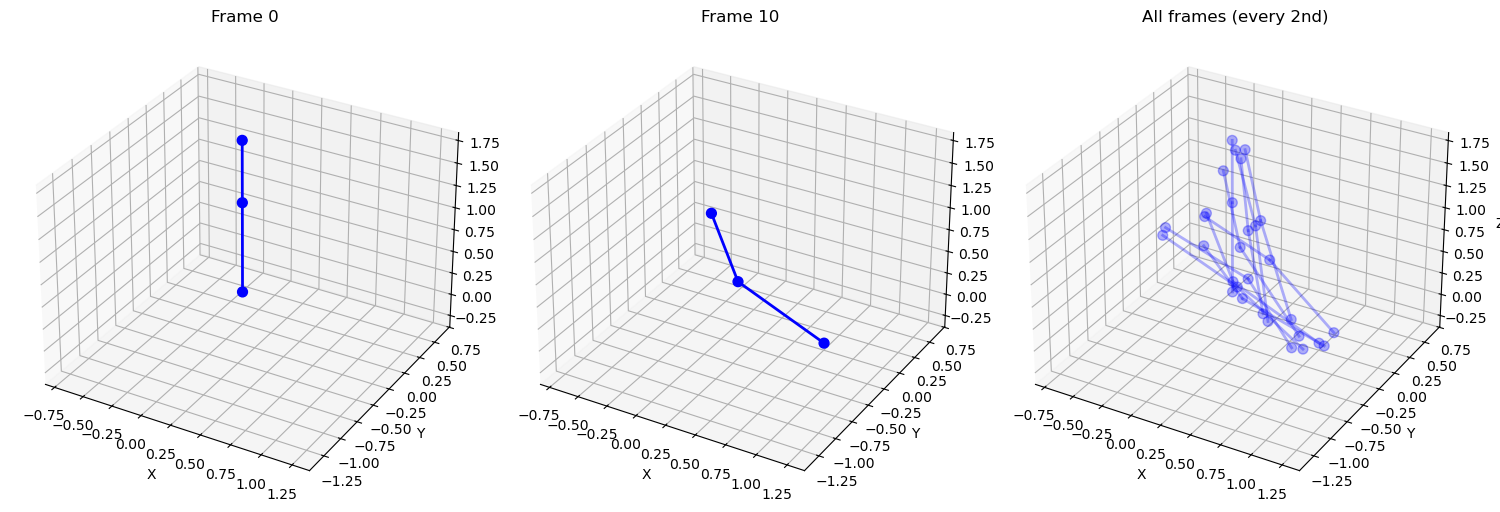

In [6]:
def plot_skeleton_3d(x, parents, time_idx=None, ax=None, title=None):
    """Plot skeleton at specific time frame(s)."""
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    if time_idx is None:
        time_idx = list(range(x.shape[0]))
    elif isinstance(time_idx, int):
        time_idx = [time_idx]
    
    # Plot multiple frames with transparency
    for t in time_idx:
        alpha = 0.3 if len(time_idx) > 1 else 1.0
        
        # Plot joints
        ax.scatter(x[t, :, 0], x[t, :, 1], x[t, :, 2], 
                   c='blue', s=50, alpha=alpha)
        
        # Plot bones
        for k in range(len(parents)):
            if parents[k] >= 0:
                parent = parents[k]
                ax.plot([x[t, parent, 0], x[t, k, 0]],
                       [x[t, parent, 1], x[t, k, 1]],
                       [x[t, parent, 2], x[t, k, 2]],
                       'b-', alpha=alpha, linewidth=2)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        ax.set_title(title)
    
    # Equal aspect ratio
    max_range = np.array([x[:, :, 0].max()-x[:, :, 0].min(),
                          x[:, :, 1].max()-x[:, :, 1].min(),
                          x[:, :, 2].max()-x[:, :, 2].min()]).max() / 2.0
    mid_x = (x[:, :, 0].max()+x[:, :, 0].min()) * 0.5
    mid_y = (x[:, :, 1].max()+x[:, :, 1].min()) * 0.5
    mid_z = (x[:, :, 2].max()+x[:, :, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    return ax

# Plot all frames
fig = plt.figure(figsize=(15, 5))

# First frame
ax1 = fig.add_subplot(131, projection='3d')
plot_skeleton_3d(x_true, parents, time_idx=0, ax=ax1, title='Frame 0')

# Middle frame
ax2 = fig.add_subplot(132, projection='3d')
plot_skeleton_3d(x_true, parents, time_idx=T//2, ax=ax2, title=f'Frame {T//2}')

# All frames overlaid
ax3 = fig.add_subplot(133, projection='3d')
plot_skeleton_3d(x_true, parents, time_idx=range(0, T, 2), ax=ax3, title='All frames (every 2nd)')

plt.tight_layout()
plt.show()

## 4. Build PyMC Hierarchical Prior Model

Implement the full hierarchical prior from GIMBAL spec.

In [29]:
with pm.Model() as skeleton_model:
    # --- Root temporal variance (only eta2[0] is used) ---
    eta2_root = pm.HalfNormal("eta2_root", sigma=0.1)
    
    # --- Skeletal parameters for non-root joints only (K-1 joints) ---
    # Root has no parent, so rho[0] = 0 by definition in GIMBAL spec
    rho = pm.HalfNormal("rho", sigma=2.0, shape=K-1)
    sigma2 = pm.HalfNormal("sigma2", sigma=0.1, shape=K-1)
    
    # --- Root joint temporal dynamics (Gaussian random walk) ---
    x_root = pm.GaussianRandomWalk("x_root", 
                                    mu=0, 
                                    sigma=pt.sqrt(eta2_root),
                                    shape=(T, 3),
                                    initval=np.zeros((T, 3)))
    
    # --- Directional vectors (vMF with uniform mean for now) ---
    # In full model, these would be conditioned on heading and pose state
    # For now, use a simple prior
    u_all = []
    for k in range(1, K):
        # Mean direction (for simplicity, point upward)
        mu_k = np.array([0., 0., 1.])
        kappa_k = pm.Exponential(f"kappa_{k}", 1.0)
        
        u_k = VonMisesFisher(f"u_{k}", mu=mu_k, kappa=kappa_k, shape=(T, 3))
        u_all.append(u_k)
    
    # --- Child joint positions ---
    x_joints = [x_root]  # Joint 0 is root
    
    for k_idx, k in enumerate(range(1, K)):
        parent_k = parents[k]
        
        # Bone length (stochastic around mean)
        # k_idx indexes into rho and sigma2 (0-based for non-root joints)
        length_k = pm.Normal(f"length_{k}", mu=rho[k_idx], sigma=pt.sqrt(sigma2[k_idx]), shape=T)
        
        # Child position = parent position + length * direction
        x_k = pm.Deterministic(f"x_{k}", 
                               x_joints[parent_k] + length_k[:, None] * u_all[k_idx])
        x_joints.append(x_k)
    
print("Skeletal model created")
print(skeleton_model)

Skeletal model created


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


## 5. Sample from Prior

Generate skeletal motions from the prior distribution.

In [30]:
with skeleton_model:
    prior_samples = pm.sample_prior_predictive(samples=50, random_seed=42)

print("Prior sampling completed")

Sampling: [eta2_root, kappa_1, kappa_2, length_1, length_2, rho, sigma2, u_1, u_2, x_root]


Prior sampling completed


## 6. Visualize Prior Samples

Sample shape: (20, 3, 3)


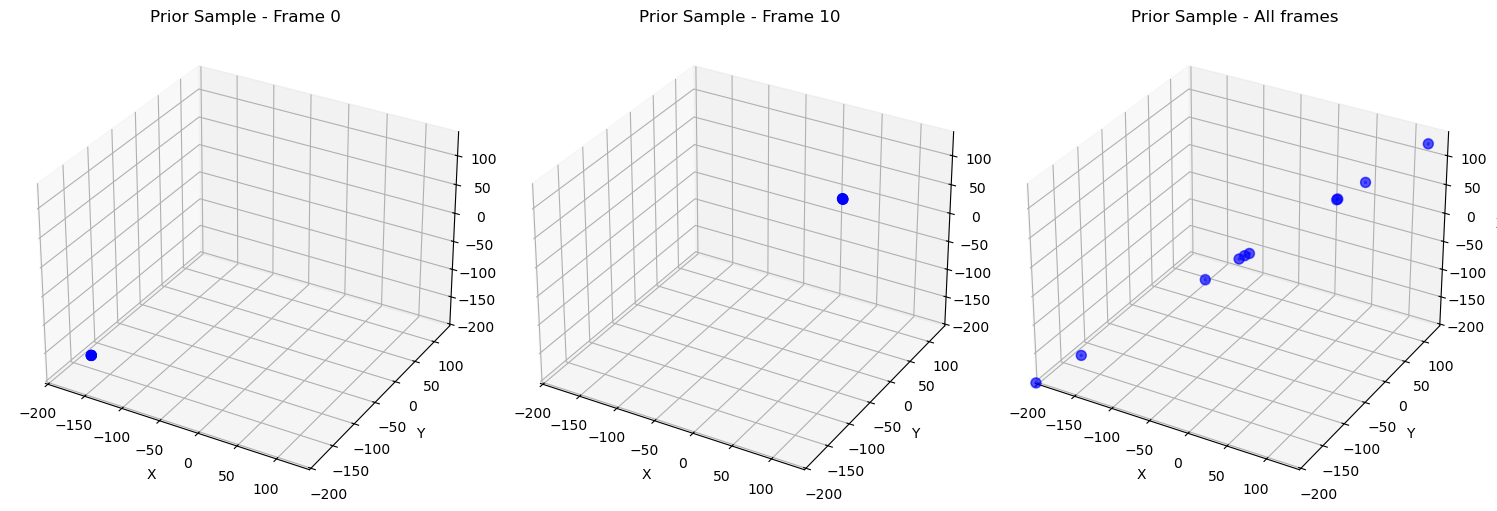

In [31]:
# Extract one sample
sample_idx = 0

# x_0 is called "x_root", x_1 and x_2 are called "x_1", "x_2"
x_parts = [prior_samples.prior["x_root"].values[0, sample_idx]]
for k in range(1, K):
    x_parts.append(prior_samples.prior[f"x_{k}"].values[0, sample_idx])

x_sample = np.stack(x_parts, axis=1)

print(f"Sample shape: {x_sample.shape}")  # Should be (T, K, 3)

# Plot sample
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
plot_skeleton_3d(x_sample, parents, time_idx=0, ax=ax1, title='Prior Sample - Frame 0')

ax2 = fig.add_subplot(132, projection='3d')
plot_skeleton_3d(x_sample, parents, time_idx=T//2, ax=ax2, title=f'Prior Sample - Frame {T//2}')

ax3 = fig.add_subplot(133, projection='3d')
plot_skeleton_3d(x_sample, parents, time_idx=range(0, T, 2), ax=ax3, title='Prior Sample - All frames')

plt.tight_layout()
plt.show()

## 7. Posterior Inference with Observed Data

Condition on the ground truth positions and infer parameters.

In [32]:
# For inference, we'll observe the joint positions and try to recover parameters
with pm.Model() as inference_model:
    # Parameters to infer (only for non-root joints)
    eta2_root = pm.HalfNormal("eta2_root", sigma=0.1)
    rho = pm.HalfNormal("rho", sigma=2.0, shape=K-1)
    sigma2 = pm.HalfNormal("sigma2", sigma=0.1, shape=K-1)
    
    # Root trajectory
    x_root = pm.GaussianRandomWalk("x_root",
                                    mu=0,
                                    sigma=pt.sqrt(eta2_root),
                                    shape=(T, 3),
                                    observed=x_true[:, 0, :])
    
    # Directional vectors and child joints
    for k_idx, k in enumerate(range(1, K)):
        parent_k = parents[k]
        
        # Infer direction from observed positions
        # Direction = (child - parent) / ||child - parent||
        diff = x_true[:, k, :] - x_true[:, parent_k, :]
        observed_u = diff / np.linalg.norm(diff, axis=1, keepdims=True)
        
        # vMF parameters
        mu_k = np.array([0., 0., 1.])
        kappa_k = pm.Exponential(f"kappa_{k}", 1.0)
        
        # Observed directions
        u_k = VonMisesFisher(f"u_{k}", mu=mu_k, kappa=kappa_k, observed=observed_u)
        
        # Observed bone lengths
        observed_lengths = np.linalg.norm(diff, axis=1)
        length_k = pm.Normal(f"length_{k}", mu=rho[k_idx], sigma=pt.sqrt(sigma2[k_idx]), 
                            observed=observed_lengths)

print("Inference model created")
print(inference_model)

Inference model created


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [33]:
# Sample posterior using nutpie for better performance
import nutpie

# Compile the model for nutpie
compiled_model = nutpie.compile_pymc_model(inference_model)

# Sample
trace = nutpie.sample(compiled_model, chains=4, tune=2000, draws=1000, 
                     target_accept=0.9, seed=123)

print("\nPosterior sampling completed")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.63,7
,3000,0,0.67,7
,3000,0,0.72,7
,3000,0,0.71,7



Posterior sampling completed


## 8. Check Parameter Recovery

In [34]:
# Summary
summary = az.summary(trace, var_names=["rho", "sigma2", "eta2_root"])
print("\nPosterior Summary:")
print(summary)


Posterior Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
rho[0]     1.003  0.027   0.953    1.052        0.0    0.001    4765.0   
rho[1]     0.807  0.019   0.773    0.844        0.0    0.000    4981.0   
sigma2[0]  0.015  0.005   0.006    0.024        0.0    0.000    5993.0   
sigma2[1]  0.007  0.003   0.003    0.011        0.0    0.000    5334.0   
eta2_root  0.201  0.036   0.136    0.269        0.0    0.001    6793.0   

           ess_tail  r_hat  
rho[0]       2535.0    1.0  
rho[1]       2578.0    1.0  
sigma2[0]    3087.0    1.0  
sigma2[1]    2753.0    1.0  
eta2_root    3441.0    1.0  


In [35]:
# Compare with ground truth
rho_post = trace.posterior["rho"].mean(dim=["chain", "draw"]).values
sigma2_post = trace.posterior["sigma2"].mean(dim=["chain", "draw"]).values
eta2_root_post = trace.posterior["eta2_root"].mean(dim=["chain", "draw"]).values

print("\nParameter Recovery:")
print("\nBone lengths (rho):")
print(f"  Joint 0 (root): true={true_rho[0]:.3f}, fixed=0.0 (no parent)")
for k_idx, k in enumerate(range(1, K)):
    print(f"  Joint {k}: true={true_rho[k]:.3f}, estimated={rho_post[k_idx]:.3f}")

print("\nBone variance (sigma2):")
print(f"  Joint 0 (root): true={true_sigma2[0]:.4f}, fixed=0.0 (no parent)")
for k_idx, k in enumerate(range(1, K)):
    print(f"  Joint {k}: true={true_sigma2[k]:.4f}, estimated={sigma2_post[k_idx]:.4f}")

print("\nTemporal variance (eta2):")
print(f"  Root joint: true={true_eta2[0]:.4f}, estimated={eta2_root_post:.4f}")


Parameter Recovery:

Bone lengths (rho):
  Joint 0 (root): true=0.000, fixed=0.0 (no parent)
  Joint 1: true=1.000, estimated=1.003
  Joint 2: true=0.800, estimated=0.807

Bone variance (sigma2):
  Joint 0 (root): true=0.0000, fixed=0.0 (no parent)
  Joint 1: true=0.0100, estimated=0.0145
  Joint 2: true=0.0100, estimated=0.0067

Temporal variance (eta2):
  Root joint: true=0.0100, estimated=0.2013


## 9. Diagnostic Plots

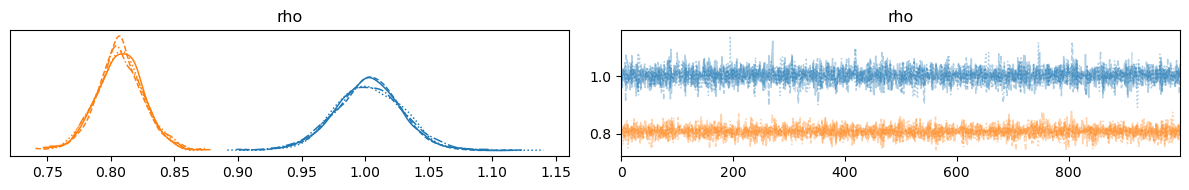

In [36]:
# Trace plots for bone lengths
az.plot_trace(trace, var_names=["rho"])
plt.tight_layout()
plt.show()

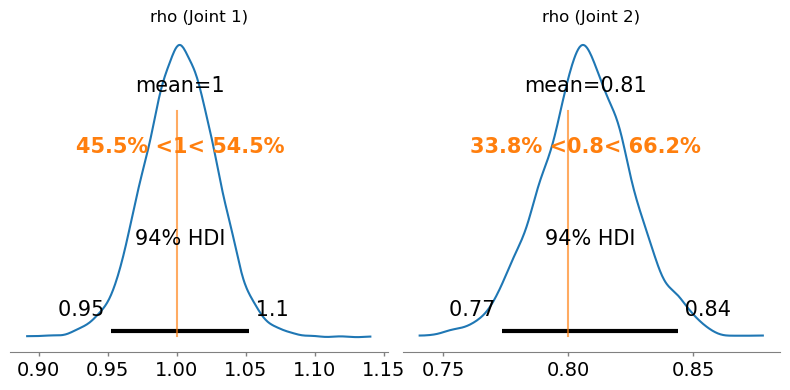

In [37]:
# Posterior plots for non-root bone lengths
fig, axes = plt.subplots(1, K-1, figsize=(8, 4))
for k_idx, k in enumerate(range(1, K)):
    ax = axes[k_idx] if K > 2 else axes
    az.plot_posterior(trace.posterior["rho"].sel(rho_dim_0=k_idx), 
                     ref_val=true_rho[k], 
                     ax=ax)
    ax.set_title(f"rho (Joint {k})")
plt.tight_layout()
plt.show()

## Summary

This notebook successfully implemented:
- ✅ Temporal dynamics with Gaussian random walk
- ✅ Skeletal constraints with hierarchical bone structure
- ✅ Directional vectors using custom vMF distribution
- ✅ Prior sampling to generate realistic skeletal motion
- ✅ Posterior inference to recover skeletal parameters

**Next steps:**
- Add pose priors (heading-dependent vMF)
- Integrate camera observations
- Add outlier mixture model